In [20]:
from shapely.geometry import Polygon
from pyproj import Geod
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.lines import Line2D
import math
import scipy
import chaosmagpy as cp
from matplotlib.path import Path
import chaosmagpy as cp
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch

In [9]:
def dx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / (2 * dxm)
    der[:, 0] = (f[:, 1] - f[:, -2]) / (2 * dxm)
    der[:, -1] = der[:, 0]
    return der

def dy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / (2 * dym)
    der[0, :] = (f[1, :] - f[0, :]) / dym
    der[1, :] = (f[-1, :] - f[-2, :]) / dym
    return der

def ddy(ym, xm, f):
    dym = np.abs(ym[1, 0] - ym[0, 0])
    der = (np.roll(f, 1, axis=0) - 2 * f + np.roll(f, -1, axis=0)) / (dym ** 2)
    der[0, :] = der[1, :]
    der[-1, :] = der[-2, :]
    return der

def ddx(ym, xm, f):
    dxm = np.abs(xm[0, 1] - xm[0, 0])
    der = (np.roll(f, 1, axis=1) - 2 * f + np.roll(f, -1, axis=1)) / (dxm ** 2)
    der[:, 0] = (f[:, 1] - 2 * f[:, 0] + f[:, -2]) / (dxm ** 2)
    der[:, -1] = der[:, 0]
    return der

def ddxy(ym, xm, f):
    df_dx = dx(ym, xm, f)
    ddf_dxy = dy(ym, xm, df_dx)
    return ddf_dxy

def detH(ddx, ddy, ddxy):
    # Hessian determinant simplified as product of second derivatives
    derH = ddx * ddy
    return derH

def K(dx, dy, ddx, ddy, ddxy):
    # Calculate Gaussian curvature
    up = (dx * ddxy * dy) + (ddxy * dy * dx) - (dx * ddy * dx) - (ddx * dy * dy)
    down = ((dx ** 2) + (dy ** 2)) ** 2
    cur = -up / down
    return cur

def mean_F(f, thetam):
    # Compute mean value of f weighted by sin(theta)
    theta_rad = np.deg2rad(thetam)
    sin_theta = np.sin(theta_rad)
    product_sum = np.sum(f[30:151, :] * sin_theta[30:151, :])
    C = np.sum(sin_theta[30:151, :])
    mean = product_sum / C
    return mean

def calculate_integral(B):
    # Calculate normalized integral over specified lat-lon regions
    phi_range = np.linspace(0, 2 * np.pi, B.shape[1] + 1)
    theta_range = np.linspace(0, np.pi, B.shape[0] + 1)

    integrals = [0, 0]
    theta_min = np.deg2rad(25)
    theta_max = np.deg2rad(155)
    region_boundaries = [
        [(0, 2 * np.pi), (0, theta_min)],
        [(0, 2 * np.pi), (theta_max, np.pi)]
    ]

    for i, region in enumerate(region_boundaries):
        for j in range(len(phi_range) - 1):
            for k in range(len(theta_range) - 1):
                phi_lower = phi_range[j]
                phi_upper = phi_range[j + 1]
                theta_lower = theta_range[k]
                theta_upper = theta_range[k + 1]
                sin_theta = np.sin((theta_lower + theta_upper) / 2)
                d_phi = phi_upper - phi_lower
                d_theta = theta_upper - theta_lower

                # Check if cell is inside region
                if region[0][0] <= (phi_lower + phi_upper) / 2 <= region[0][1] and \
                   region[1][0] <= (theta_lower + theta_upper) / 2 <= region[1][1]:
                    integrals[i] += B[k, j] * sin_theta * d_phi * d_theta

    integral = sum(integrals)
    return integral

def F_boundary(constant, B, B_t0):
    # Compute boundary F
    Fup = calculate_integral(B)
    Fdown = calculate_integral(B_t0)
    F_out = Fup / Fdown
    boundaryF = constant * F_out
    return boundaryF

def detH_saddle(DETH, thetam, phim, crossingsX, crossingsY):
    # Separate saddle and extrema points using interpolated DETH
    lat_grid = thetam[:, 0]
    lon_grid = phim[0, :]
    interp_func = scipy.interpolate.RegularGridInterpolator(
        (lat_grid, lon_grid),
        DETH,
        bounds_error=False,
        fill_value=np.nan
    )

    cross = np.column_stack((crossingsX, crossingsY))
    points_for_interp = cross[:, [1, 0]]

    # Interpolate values
    values = interp_func(points_for_interp)

    # Classify positive and negative points
    pos_mask = values > 0
    neg_mask = values <= 0
    pos_points = points_for_interp[pos_mask]
    neg_points = points_for_interp[neg_mask]

    return pos_points, neg_points

def F_C_ObO(x, y, fun1, fun2, lev):
    c_fx = plt.contour(x, y, fun1, levels=[lev])
    c_fy = plt.contour(x, y, fun2, levels=[lev])

    Line_dx = []
    points_dx = []
    paths = c_fx.get_paths()
    polygons = paths[0].to_polygons()

    for i, poly in enumerate(polygons):
        verts = poly
        if abs(verts[-1, 0] - verts[-2, 0]) > 10 or abs(verts[-1, 1] - verts[-2, 1]) > 10:
            zz = 2
        else:
            zz = 1
        points_dx.extend(verts)
        FxLine = []

        for v in range(len(verts) - zz):
            xa, ya = verts[v]
            xb, yb = verts[v + 1]
            xlist = np.array([xa, xb])
            ylist = np.array([ya, yb])

            # Skip if two points are too close (to avoid polyfit failure)
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue

            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"Warning: polyfit failed for points ({xa}, {ya}) - ({xb}, {yb}), skipped.")
                continue

            k, b = np.polyfit(xlist, ylist, deg=1)
            FxLine.append([k, b, xa, xb, ya, yb])

        Line_dx.append(np.array(FxLine))

    Line_dy = []
    points_dy = []
    paths = c_fy.get_paths()
    polygons = paths[0].to_polygons()

    for i, poly in enumerate(polygons):
        verts = poly
        if abs(verts[-1, 0] - verts[-2, 0]) > 10 or abs(verts[-1, 1] - verts[-2, 1]) > 10:
            zz = 2
        else:
            zz = 1
        points_dy.extend(verts)
        FyLine = []

        for v in range(len(verts) - zz):
            xa, ya = verts[v]
            xb, yb = verts[v + 1]
            xlist = np.array([xa, xb])
            ylist = np.array([ya, yb])

            # Skip if two points are too close (to avoid polyfit failure)
            if np.isclose(xa, xb) and np.isclose(ya, yb):
                continue

            try:
                k, b = np.polyfit([xa, xb], [ya, yb], deg=1)
            except np.linalg.LinAlgError:
                print(f"Warning: polyfit failed for points ({xa}, {ya}) - ({xb}, {yb}), skipped.")
                continue

            k, b = np.polyfit(xlist, ylist, deg=1)
            FyLine.append([k, b, xa, xb, ya, yb])

        Line_dy.append(np.array(FyLine))

    x_cross = []
    y_cross = []

    for n in range(len(Line_dx)):
        Fx = Line_dx[n]
        for m in range(len(Line_dy)):
            Fy = Line_dy[m]
            for p in range(len(Fx[:, 0])):
                k1, b1, x1, x2, y1, y2 = Fx[p, :]
                for q in range(len(Fy[:, 0])):
                    k2, b2, x3, x4, y3, y4 = Fy[q, :]
                    x_c = (b2 - b1) / (k1 - k2)
                    if x_c is not None:
                        # Check if x_c is within the x-range of both line segments
                        in_range_1 = (min(x1, x2) <= x_c <= max(x1, x2))
                        in_range_2 = (min(x3, x4) <= x_c <= max(x3, x4))
                        if in_range_1 and in_range_2:
                            y_c = k1 * x_c + b1
                            if y_c is not None:
                                # Check if y_c is within the y-range of both line segments
                                in_range_3 = (min(y1, y2) <= y_c <= max(y1, y2))
                                in_range_4 = (min(y3, y4) <= y_c <= max(y3, y4))
                                if in_range_3 and in_range_4:
                                    x_cross.append(x_c)
                                    y_cross.append(y_c)

    x_cross = np.array(x_cross)
    y_cross = np.array(y_cross)

    # Keep only points with y in [5, 175]
    mask = (y_cross >= 5) & (y_cross <= 175)
    x_cross = x_cross[mask]
    y_cross = y_cross[mask]

    return x_cross, y_cross


def detH_saddle(DETH, thetam, phim, crossingsX, crossingsY):
    lat_grid = thetam[:, 0]
    lon_grid = phim[0, :]
    interp_func = scipy.interpolate.RegularGridInterpolator((lat_grid, lon_grid), DETH, bounds_error=False, fill_value=np.nan)

    cross = np.column_stack((crossingsX, crossingsY))
    cross = np.array(cross)
    points_for_interp = cross[:, [1, 0]]

    # Interpolate DETH values at crossing points
    values = interp_func(points_for_interp)

    # Separate points based on sign of interpolated DETH
    pos_mask = values > 0
    neg_mask = values <= 0
    pos_points = points_for_interp[pos_mask]
    neg_points = points_for_interp[neg_mask]

    return pos_points, neg_points

# Compute main magnetic field at grid points
def magnetic_point(gsh, hsh, lmax, r, lats, lons):
    a = 6371.2
    pi = math.pi
    # lons2d and lats2d are assumed to be 2D arrays of coordinates
    lons2d, lats2d = lons, lats
    phi = lons2d
    cost2d = np.cos((lats2d) * np.pi / 180)
    i = 0
    br = np.zeros(cost2d.shape)
    bphi = np.zeros(cost2d.shape)
    btheta = np.zeros(cost2d.shape)
    
    for l in np.arange(1, lmax + 1, 1):
        for m in np.arange(0, l + 1, 1):
            g = gsh[i]
            h = hsh[i]
            # Calculate Schmidt quasi-normalization factor
            if m == 0:
                schmidt = 1.0
            else:
                schmidt = ((-1.0) ** m) * np.sqrt(2.0 * math.factorial(l - m) / math.factorial(l + m))
            lagendre = scipy.special.lpmv(m, l, cost2d)
            lagendre_ = scipy.special.lpmv(m, l - 1, cost2d)
            div_lagendre = (l * cost2d * lagendre - (l + m) * lagendre_) / np.sqrt(1 - cost2d ** 2)
            br = br + schmidt * (float(l) + 1.0) * ((a / r) ** (l + 2)) * lagendre * (
                        g * np.cos(float(m) * phi * pi / 180.0) + h * np.sin(float(m) * phi * pi / 180.0))
            bphi = bphi + schmidt * (m / np.sin((lats2d) * pi / 180)) * ((a / r) ** (l + 2)) * lagendre * (
                        -g * np.sin(float(m) * phi * pi / 180.0) + h * np.cos(float(m) * phi * pi / 180.0))
            btheta = btheta + schmidt * ((a / r) ** (l + 2)) * div_lagendre * (
                        g * np.cos(float(m) * phi * pi / 180.0) + h * np.sin(float(m) * phi * pi / 180.0))
            i += 1
    return br, bphi, btheta, lons2d, lats2d


# Compute magnetic intensity at specific points
def magnetic_point(gsh, hsh, lmax, r, y, x):
    fi = []
    for i in range(len(y)):
        br, bphi, btheta, _, _ = magnetic_field(gsh, hsh, lmax, radius, y[i], x[i])
        fff = np.sqrt(br**2 + bphi**2 + btheta**2) / 1000
        fi.append(fff)
    return np.array(fi).squeeze()


In [10]:
radius = 6371.
theta = np.linspace(1., 179., num=181)  # colatitude in degrees
phi = np.linspace(0., 360., num=361)  # longitude in degrees
phim, thetam = np.meshgrid(phi, theta)
radiusm = radius * np.ones(phim.shape)
model = cp.load_CHAOS_matfile('D:\Fig\origin data\coeff\CHAOS-8.2.mat')
time2020 = cp.data_utils.mjd2000(2020, 1, 1)  # modified Julian date
B_radius, B_theta, B_phi = model.synth_values_tdep(time2020, radiusm, thetam, phim)
F2020 = np.sqrt(B_radius ** 2 + B_theta ** 2 + B_phi ** 2) / 1000
Fo2020 = calculate_integral(F2020)

D:\Anaconda\envs\Saddle\Lib\site-packages\chaosmagpy\chaos.py:2873: UserWarning: Missing ionospheric field coefficients: 'model_ion'
  warnings.warn(f'Missing ionospheric field coefficients: {err}')


2020


D:\Anaconda\envs\Saddle\Lib\site-packages\numpy\lib\_polynomial_impl.py:674: RuntimeWarning: invalid value encountered in divide
  lhs /= scale


Area number= 2 
 Area= [13206657.05690483   899019.53951746]


D:\Anaconda\envs\Saddle\Lib\site-packages\cartopy\mpl\geoaxes.py:1585: UserWarning: The following kwargs were not used by contour: 'label'
  result = super().contour(*args, **kwargs)


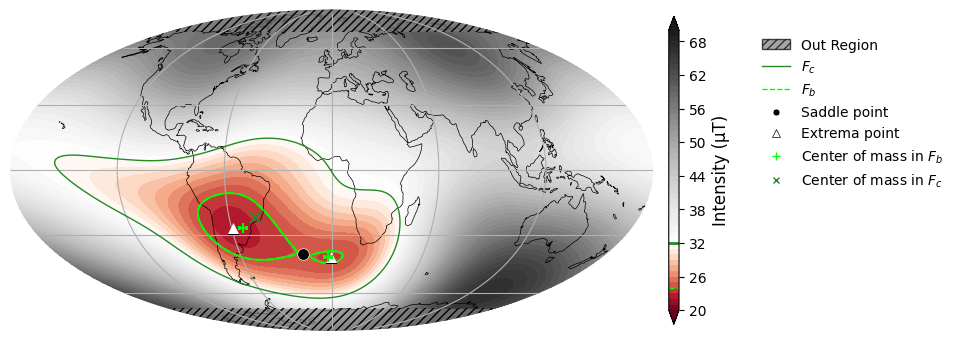

In [28]:
#%%
# Create a proxy Patch for the legend
polar_patch = Patch(facecolor='gray', edgecolor='k', hatch='////', label='Out Region', alpha=0.7)
# polar_patch = Patch(facecolor='gray', alpha=0.7, edgecolor='none',label='Out Region',hatch='////')

cmap="RdGy"# 'PuOr_r'
linecolor="forestgreen"
vmin = 20
vmax = 70

fontweight='bold'
fontname='Arial'
fontsize=14
markersize = 70
SaddleColor="k"
SaddleMarker="o"
ExtremaColor="white"
ExtremaMarker="^"

massmarker_Fs="+"
massmarker="x"
masscolor="forestgreen"
masssize=60
subregionCMcolor='lime'


fig, (ax1) = plt.subplots(1, 1, figsize=(10, 8),subplot_kw={'projection': ccrs.Mollweide()})

yr=2020
print(yr)
time = cp.data_utils.mjd2000(yr, 1, 1)  # modified Julian date
B_radius, B_theta, B_phi = model.synth_values_tdep(time, radiusm, thetam, phim)
F = np.sqrt(B_radius ** 2 + B_theta ** 2 + B_phi ** 2) / 1000
Fout = calculate_integral(F)
Fc = 32 * (Fout / Fo2020)

vcenter = Fc  # 想让这个值为白色
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

F_real = F
d_x = dx(thetam, phim, F_real)
d_y = dy(thetam, phim, F_real)
dd_x = ddx(thetam, phim, F_real)
dd_y = ddy(thetam, phim, F_real)
dd_xy = ddxy(thetam, phim, F_real)
DETH = detH(dd_x, dd_y, dd_xy)
crossingsX1, crossingsY1= F_C_ObO(phi, theta, d_x, d_y,0)
E, S = detH_saddle(DETH, thetam, phim, crossingsX1, crossingsY1)
H_S_lat, H_S_lon=S[:,0],S[:,1]
H_E_lat, H_E_lon=E[:,0],E[:,1]

c_fo = plt.contour(phi, theta, F, levels=[Fc])   # get contour
paths = c_fo.get_paths()          # get contour path(all)
polygons1 = paths[0].to_polygons()
area_same_fo=[]
# 准备网格点坐标
lat_grid = 90 - thetam    # 纬度 φ
lon_grid = phim           # 经度 φ
theta_grid = thetam

# 准备存储结果
centers_phi_theta = []
All_phi_inside = []
All_theta_inside = []
All_F_inside = []
# 遍历每个封闭区域
for path in paths:
    for poly in path.to_polygons():
        poly_lats = 90 - poly[:, 1]
        poly_lons = poly[:, 0]

        polygon_path = Path(np.vstack([poly_lons, poly_lats]).T)
        grid_points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T

        inside = polygon_path.contains_points(grid_points)
        if not np.any(inside):
            continue

        # 提取区域内的经度、余纬和磁强度
        phi_in = grid_points[inside, 0]                      # 经度
        theta_in = theta_grid.ravel()[inside]                # 余纬
        F_in = F.ravel()[inside]                             # 磁场强度

        All_phi_inside.append(phi_in)
        All_theta_inside.append(theta_in)
        All_F_inside.append(F_in)

All_phi_inside = np.concatenate(All_phi_inside)
All_theta_inside = np.concatenate(All_theta_inside)
All_F_inside = np.concatenate(All_F_inside)
All_phi_inside = ((All_phi_inside + 180) % 360) - 180
# 加权计算质心
w_sum = (1/All_F_inside)
w_sin = np.sin(All_theta_inside*np.pi/180)
phi_cm_Fc = np.sum(All_phi_inside * w_sum * w_sin) / np.sum(w_sum * w_sin)
phi_cm_Fc = phi_cm_Fc % 360
theta_cm_Fc = np.sum(All_theta_inside * w_sin  *  w_sum ) /  np.sum(w_sum * w_sin)           # 保留余纬



ax1.set_global()
ax1.coastlines(color='k', linewidth=0.5)
ax1.add_feature(cfeature.LAND, facecolor='lightgray', linewidth=0.5)
ax1.gridlines(draw_labels=False)
for spine in ax1.spines.values():
    spine.set_visible(False)

C = np.linspace(20,70, 51)
cs = ax1.contourf(phi, 90 - theta, F,C,cmap=cmap, transform=ccrs.PlateCarree(),extend="both",norm=norm)
ax1.contour(phi, 90 - theta, F, levels=[Fc], colors=linecolor, linewidths=1, transform=ccrs.PlateCarree(),label="Fc")

# F minima find
B_radius_min, B_theta_min, B_phi_min = model.synth_values_tdep(time, radius, H_E_lat,H_E_lon,grid=True)
F_mini = np.sqrt(B_radius_min ** 2 + B_theta_min ** 2 + B_phi_min ** 2) / 1000
pek_f=[]
pek_lat=[]
pek_lon=[]
for i in range(0,len(H_E_lat)):
    if F_mini[i,i] < Fc:
        pek_f.append( F_mini[i,i])
        pek_lat.append(H_E_lat[i])
        pek_lon.append(H_E_lon[i])
pek_f = np.array(pek_f)
pek_lat = np.array(pek_lat)
pek_lon = np.array(pek_lon)
# F saddle 的计算
B_radius, B_theta, B_phi = model.synth_values_tdep(time, radius, H_S_lat,H_S_lon,grid=True)
F_saddle = np.sqrt(B_radius ** 2 + B_theta ** 2 + B_phi ** 2) / 1000
F_right=[]
for i in range(0,len(H_S_lat)):
    if F_saddle[i,i] < Fc:
        F_right = F_saddle[i,i]
        saddle_lat=H_S_lat[i]
        saddle_lon=H_S_lon[i]

Saddle_centers_phi_theta = []
Fs_phi_inside = []
Fs_theta_inside = []
Fs_F_inside = []
if F_right:  # if have Saddle point
    c_fc = plt.contour(phi, theta, F, levels=[F_right*0.999])
    num_contours = len(c_fc.get_paths())
    paths = c_fc.get_paths()
    polygons = paths[0].to_polygons()
    cs2 = ax1.contour(phi, 90 - theta, F, levels=[F_right * 0.999], colors=subregionCMcolor, linewidths=1, transform=ccrs.PlateCarree())
    for seg in cs2.allsegs[0]:  # 0 for first level
        x, y = seg[:, 0], seg[:, 1]
        ax1.plot(x, y, linestyle="dashed", color=subregionCMcolor, transform=ccrs.PlateCarree())
    selected_polygon = None
    area_array=[]
    area_dif=[]
    area_same=[]
    for i, poly in enumerate(polygons):
        lats= 90-poly[:, 1]
        lons= poly[:, 0]

        geod = Geod(ellps="WGS84")
        polygon = Polygon(zip(lons, lats))
        area, _ = geod.geometry_area_perimeter(polygon)
        area_km2 = abs(area) / 1e6

        poly_lats = 90 - poly[:, 1]
        poly_lons = poly[:, 0]

        polygon_path = Path(np.vstack([poly_lons, poly_lats]).T)
        grid_points = np.vstack([lon_grid.ravel(), lat_grid.ravel()]).T

        inside = polygon_path.contains_points(grid_points)
        if not np.any(inside):
            continue

        # 提取区域内的经度、余纬和磁强度
        phi_in = grid_points[inside, 0]                      # 经度
        theta_in = theta_grid.ravel()[inside]                # 余纬
        F_in = F.ravel()[inside]                             # 磁场强度

        if ((lons >= 0) & (lons <= 1)).any() or ((lons >= 359) & (lons <= 360)).any():
            area_same.append(area_km2)

            # 遇到0°需要加和
            Fs_phi_inside.append(phi_in)
            Fs_theta_inside.append(theta_in)
            Fs_F_inside.append(F_in)

        else:
            area_dif.append(area_km2)
            # 加权计算质心
            w_sum = 1 / F_in
            w_sin = np.sin(theta_in * np.pi / 180)
            phi_cm = np.sum(phi_in * w_sum * w_sin) / np.sum(w_sum * w_sin)
            theta_cm = np.sum(theta_in * w_sum * w_sin) / np.sum(w_sum * w_sin)  # 保留余纬

            Saddle_centers_phi_theta.append((phi_cm, theta_cm))



        #center of mass 计算
    Fs_phi_inside = np.concatenate(Fs_phi_inside)
    Fs_theta_inside = np.concatenate(Fs_theta_inside)
    Fs_F_inside = np.concatenate(Fs_F_inside)
    Fs_phi_inside = ((Fs_phi_inside + 180) % 360) - 180  # 映射到 [-180, 180]
    # 加权计算质心
    w_sum =  (1 / Fs_F_inside)
    w_sin = np.sin(Fs_theta_inside * np.pi / 180)
    phi_cm_Fs = np.sum(Fs_phi_inside * w_sin * w_sum) / np.sum(w_sum * w_sin)
    phi_cm_Fs = phi_cm_Fs % 360
    theta_cm_Fs = np.sum(Fs_theta_inside * w_sin * w_sum) / np.sum(w_sum * w_sin)
    Saddle_centers_phi_theta.append((phi_cm_Fs, theta_cm_Fs))
    Saddle_centers_phi_theta = np.array(Saddle_centers_phi_theta)

    #面积计算
    area_same_total = np.sum(area_same)

    area_dif = np.array(area_dif)
    area_array = np.hstack([area_dif, area_same_total])
    print("Area number=",len(area_array),"\n Area=",area_array)
    ax1.scatter(Saddle_centers_phi_theta[:, 0], 90 - Saddle_centers_phi_theta[:, 1], color=subregionCMcolor,
               marker=massmarker_Fs, s=masssize, transform=ccrs.PlateCarree(), zorder=5)
    legend_elements1 = [
        polar_patch,
        Line2D([0], [0], color=linecolor, lw=1 , label=r'$F_c$'),
        Line2D([0], [0], color=subregionCMcolor, lw=1 , label=r'$F_{b}$', linestyle='dashed'),
        Line2D([0], [0], marker=SaddleMarker, color=SaddleColor, label='Saddle point', markersize=5, linestyle='None', markeredgecolor='white',markeredgewidth=0.5),
        Line2D([0], [0], color=ExtremaColor, marker=ExtremaMarker,label='Extrema point', markersize=6, linestyle='None', markeredgecolor='k',markeredgewidth=0.5),
        Line2D([0], [0], marker=massmarker_Fs, color=subregionCMcolor, label='Center of mass in $F_{b}$', markersize=6,linestyle='None'),
        Line2D([0], [0], marker=massmarker, color=masscolor, label='Center of mass in $F_c$', markersize=5, linestyle='None')

    ]
else:
    print("No Fsaddle")
    legend_elements1 = [
        polar_patch,
        Line2D([0], [0], color=linecolor, lw=1 , label=r'$F_c$'),
        Line2D([0], [0], marker=SaddleMarker, color=SaddleColor, label='Saddle point', markersize=5, linestyle='None'),
        Line2D([0], [0], color=ExtremaColor, marker=ExtremaMarker,label='Minima point', markersize=6, linestyle='None', markeredgecolor='k',markeredgewidth=0.5),
        Line2D([0], [0], marker=massmarker, color=masscolor, label='Center of mass in $F_c$', markersize=5,
               linestyle='None')
    ]

ax1.scatter(pek_lon,90-pek_lat,color=ExtremaColor, marker=ExtremaMarker, s=markersize, transform=ccrs.PlateCarree(), zorder=4,edgecolors="k",linewidths=0.1)
ax1.scatter(saddle_lon, 90 - saddle_lat, color=SaddleColor, marker=SaddleMarker ,s=markersize, transform=ccrs.PlateCarree(), zorder=5,edgecolors="white",linewidths=0.5)
# ax1.set_title("Anomaly Boundary Fc and Fsaddle in {}".format(yr), fontsize=14)
# cente of mass
ax1.scatter(phi_cm_Fc, 90 - theta_cm_Fc, color=masscolor, marker=massmarker ,s=masssize, transform=ccrs.PlateCarree(), zorder=5)

ax1.legend(
    handles=legend_elements1,
    loc='upper left',              # 图例“对齐方式”
    bbox_to_anchor=(1.15, 0.95),     # 图外右上角，x=1.2表示往右移动，y=1.0表示顶部对齐
    frameon=False)
# ax1.legend(handles=legend_elements1, loc='best')
cbar = fig.colorbar(cs, ax=ax1, orientation='vertical', pad=0.02, aspect=30,shrink=0.5)
cbar.set_label("Intensity (μT)", fontsize=12)
cbar.ax.axhline(Fc, color=linecolor, linewidth=2)
cbar.ax.axhline(F_right*0.999, color=subregionCMcolor, linewidth=1,linestyle='dashed')

# 创建灰色蒙版：纬度 > 30 和 < -30 的区域
lon = np.linspace(-180, 180, 361)

cbar.ax.axvline(Fc, color='goldenrod', linewidth=2)
# cb.ax.text(Fb, 1.05, f'$F_b={Fb:.1f}$', color='goldenrod',ha='center', va='bottom', transform=cb.ax.transData, fontsize=9)


# 北极区
lat1 = 70
poly1 = Polygon(list(zip(lon, [lat1]*len(lon))) + list(zip(lon[::-1], [90]*len(lon))))
# 南极区
lat2 = -70
poly2 = Polygon(list(zip(lon, [lat2]*len(lon))) + list(zip(lon[::-1], [-90]*len(lon))))

# 添加到图上
ax1.add_geometries([poly1, poly2], crs=ccrs.PlateCarree(),
                   facecolor='gray', alpha=0.7, edgecolor='none',hatch='////')


# plt.show()
# fig.savefig("D:\\work\\work_saddle\\Latex_saddle\\Fig\\New-color\\4a_Area.png", dpi=300, bbox_inches='tight')